In [15]:

import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RepeatedKFold, LeaveOneOut
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from scipy.stats import shapiro, pearsonr, spearmanr
from sklearn.linear_model import LinearRegression

import eda
import present_value

%load_ext autoreload
%autoreload 2
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pv = present_value.PresentValue()
anual_increment = pv.fetch_salary_increase_per_year()

filename = "../data/raw/BASE DE DATOS PRESUPUESTOS.xlsx"
preproccesing = eda.EDA(filename)
df = preproccesing.create_dataset(pv.present_value_costs)

c:\Code\practicum\src\eda.py:135: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = (df[cols] / totals).fillna(0)


In [3]:
def remove_outliers(df, target: str) -> pd.DataFrame:
    q1, q3 = df[target].quantile(0.05), df[target].quantile(0.95)
    iqr = q3 - q1
    x_clean = (df[target] >= q1 - 1.5*iqr) & (df[target] <= q3 + 1.5*iqr) & (df[target] != 0)
    
    df_clean = df[x_clean]
    return df_clean

# 🔍 DEEP DATA EXPLORATION

## Questions to Answer:
1. **Distribution**: Should we use log transformation on input, target, both, or neither?
2. **Heteroscedasticity**: Are the error variances constant across the range?
3. **Scale**: Do we need standardization/normalization?
4. **Relationships**: What's the actual pattern between variables?


In [13]:
# Prepare your data
predictor_name = 'LONGITUD KM'
hue_name = 'ALCANCE'
target_name = '2.2 TRAZADO Y DISEÑO GEOMÉTRICO'

df_item = df.loc[:, [predictor_name, hue_name, target_name]].copy()
df_item_cleaned = remove_outliers(df_item, target_name)

print(f"Dataset size: {len(df_item_cleaned)} samples")
print(f"Predictor (X): {predictor_name}")
print(f"Categorical: {hue_name}")
print(f"Target (y): {target_name}")
print(f"\nCategories in {hue_name}: {df_item_cleaned[hue_name].unique()}")

Dataset size: 48 samples
Predictor (X): LONGITUD KM
Categorical: ALCANCE
Target (y): 2.2 TRAZADO Y DISEÑO GEOMÉTRICO

Categories in ALCANCE: ['Segunda calzada' 'Rehabilitación' 'Nuevo' 'Cosntrucción '
 'Puesta a punto' 'Mejoramiento' 'Construcción ']


In [16]:
def comprehensive_eda(df_clean, predictor_name, hue_name, target_name):
    """
    Deep exploratory analysis to determine transformations and heteroscedasticity
    """
    X_raw = df_clean[predictor_name].values
    y_raw = df_clean[target_name].values
    categories = df_clean[hue_name].values
    
    # Remove any zeros to allow log transformation
    mask = (X_raw > 0) & (y_raw > 0)
    X_raw = X_raw[mask]
    y_raw = y_raw[mask]
    categories = categories[mask]
    
    # Create transformations
    X_log = np.log(X_raw)
    y_log = np.log(y_raw)
    
    print("="*80)
    print("📊 DATA SCALE ANALYSIS")
    print("="*80)
    print(f"\n{predictor_name}:")
    print(f"  Range: {X_raw.min():,.2f} to {X_raw.max():,.2f}")
    print(f"  Mean: {X_raw.mean():,.2f}, Median: {np.median(X_raw):,.2f}")
    print(f"  Units: Measured in thousands (km)")
    
    print(f"\n{target_name}:")
    print(f"  Range: {y_raw.min():,.0f} to {y_raw.max():,.0f}")
    print(f"  Mean: {y_raw.mean():,.0f}, Median: {np.median(y_raw):,.0f}")
    print(f"  Units: Measured in hundreds of millions")
    print(f"  Scale difference: {y_raw.mean() / X_raw.mean():,.0f}x larger than predictor")
    
    print(f"\n💡 SCALE RECOMMENDATION:")
    print(f"  YES - Use StandardScaler! Your variables have vastly different scales.")
    print(f"  StandardScaler will transform both to mean=0, std=1 for fair comparison.")
    
    # Distribution analysis
    print("\n" + "="*80)
    print("📈 DISTRIBUTION ANALYSIS (Normality Tests)")
    print("="*80)
    
    def test_normality(data, name):
        stat, p_value = shapiro(data[:50] if len(data) > 50 else data)  # Shapiro limited to 50 samples
        skewness = stats.skew(data)
        kurtosis = stats.kurtosis(data)
        
        print(f"\n{name}:")
        print(f"  Shapiro-Wilk p-value: {p_value:.4f} {'✓ Normal' if p_value > 0.05 else '✗ Not normal'}")
        print(f"  Skewness: {skewness:.3f} {'(symmetric)' if abs(skewness) < 0.5 else '(skewed!)'}")
        print(f"  Kurtosis: {kurtosis:.3f} {'(normal)' if abs(kurtosis) < 1 else '(heavy tails!)'}")
        
        return p_value > 0.05
    
    x_normal = test_normality(X_raw, f"{predictor_name} (raw)")
    x_log_normal = test_normality(X_log, f"{predictor_name} (log)")
    y_normal = test_normality(y_raw, f"{target_name} (raw)")
    y_log_normal = test_normality(y_log, f"{target_name} (log)")
    
    # Correlation analysis
    print("\n" + "="*80)
    print("🔗 RELATIONSHIP ANALYSIS")
    print("="*80)
    
    # Test different transformation combinations
    transformations = [
        ("Raw X vs Raw Y", X_raw, y_raw),
        ("Log X vs Raw Y", X_log, y_raw),
        ("Raw X vs Log Y", X_raw, y_log),
        ("Log X vs Log Y (log-log)", X_log, y_log)
    ]
    
    best_r2 = -np.inf
    best_transform = None
    
    print("\nLinear regression R² for different transformations:")
    for name, X_test, y_test in transformations:
        # Fit simple linear regression
        model = LinearRegression()
        model.fit(X_test.reshape(-1, 1), y_test)
        r2 = model.score(X_test.reshape(-1, 1), y_test)
        
        # Pearson and Spearman correlations
        pearson_r, _ = pearsonr(X_test, y_test)
        spearman_r, _ = spearmanr(X_test, y_test)
        
        print(f"\n  {name}:")
        print(f"    R² (linearity): {r2:.4f}")
        print(f"    Pearson r: {pearson_r:.4f} (linear correlation)")
        print(f"    Spearman ρ: {spearman_r:.4f} (monotonic correlation)")
        
        if r2 > best_r2:
            best_r2 = r2
            best_transform = (name, X_test, y_test)
    
    print(f"\n🏆 Best transformation: {best_transform[0]} with R² = {best_r2:.4f}")
    
    # Heteroscedasticity test
    print("\n" + "="*80)
    print("📉 HETEROSCEDASTICITY ANALYSIS")
    print("="*80)
    
    def test_heteroscedasticity(X, y, transform_name):
        # Fit linear regression
        model = LinearRegression()
        model.fit(X.reshape(-1, 1), y)
        y_pred = model.predict(X.reshape(-1, 1))
        residuals = y - y_pred
        
        # Calculate residuals squared
        residuals_sq = residuals ** 2
        
        # Breusch-Pagan test (simplified): regress squared residuals on X
        bp_model = LinearRegression()
        bp_model.fit(X.reshape(-1, 1), residuals_sq)
        bp_r2 = bp_model.score(X.reshape(-1, 1), residuals_sq)
        
        # If residuals_sq are correlated with X, we have heteroscedasticity
        print(f"\n{transform_name}:")
        print(f"  Residuals² vs X correlation (R²): {bp_r2:.4f}")
        
        if bp_r2 < 0.1:
            print(f"  ✓ Homoscedastic (constant variance) - GOOD!")
        elif bp_r2 < 0.3:
            print(f"  ⚠️ Mild heteroscedasticity")
        else:
            print(f"  ✗ Strong heteroscedasticity - variance changes with X!")
        
        # Calculate variance in bins
        X_sorted_idx = np.argsort(X)
        n = len(X)
        bin_size = max(3, n // 3)
        
        bin1_var = np.var(residuals[X_sorted_idx[:bin_size]])
        bin3_var = np.var(residuals[X_sorted_idx[-bin_size:]])
        
        print(f"  Variance ratio (high X / low X): {bin3_var / bin1_var if bin1_var > 0 else np.inf:.2f}")
        print(f"    (Ratio near 1.0 is good, >3 suggests heteroscedasticity)")
        
        return bp_r2
    
    # Test heteroscedasticity for each transformation
    for name, X_test, y_test in transformations:
        test_heteroscedasticity(X_test, y_test, name)
    
    return best_transform

# Run comprehensive analysis
best_transform_result = comprehensive_eda(df_item_cleaned, predictor_name, hue_name, target_name)


📊 DATA SCALE ANALYSIS

LONGITUD KM:
  Range: 0.80 to 50.90
  Mean: 12.49, Median: 8.80
  Units: Measured in thousands (km)

2.2 TRAZADO Y DISEÑO GEOMÉTRICO:
  Range: 1,869,655 to 214,060,284
  Mean: 24,764,679, Median: 12,711,059
  Units: Measured in hundreds of millions
  Scale difference: 1,983,048x larger than predictor

💡 SCALE RECOMMENDATION:
  YES - Use StandardScaler! Your variables have vastly different scales.
  StandardScaler will transform both to mean=0, std=1 for fair comparison.

📈 DISTRIBUTION ANALYSIS (Normality Tests)

LONGITUD KM (raw):
  Shapiro-Wilk p-value: 0.0000 ✗ Not normal
  Skewness: 1.675 (skewed!)
  Kurtosis: 2.826 (heavy tails!)

LONGITUD KM (log):
  Shapiro-Wilk p-value: 0.2791 ✓ Normal
  Skewness: -0.372 (symmetric)
  Kurtosis: -0.500 (normal)

2.2 TRAZADO Y DISEÑO GEOMÉTRICO (raw):
  Shapiro-Wilk p-value: 0.0000 ✗ Not normal
  Skewness: 3.590 (skewed!)
  Kurtosis: 15.038 (heavy tails!)

2.2 TRAZADO Y DISEÑO GEOMÉTRICO (log):
  Shapiro-Wilk p-value: 0.391

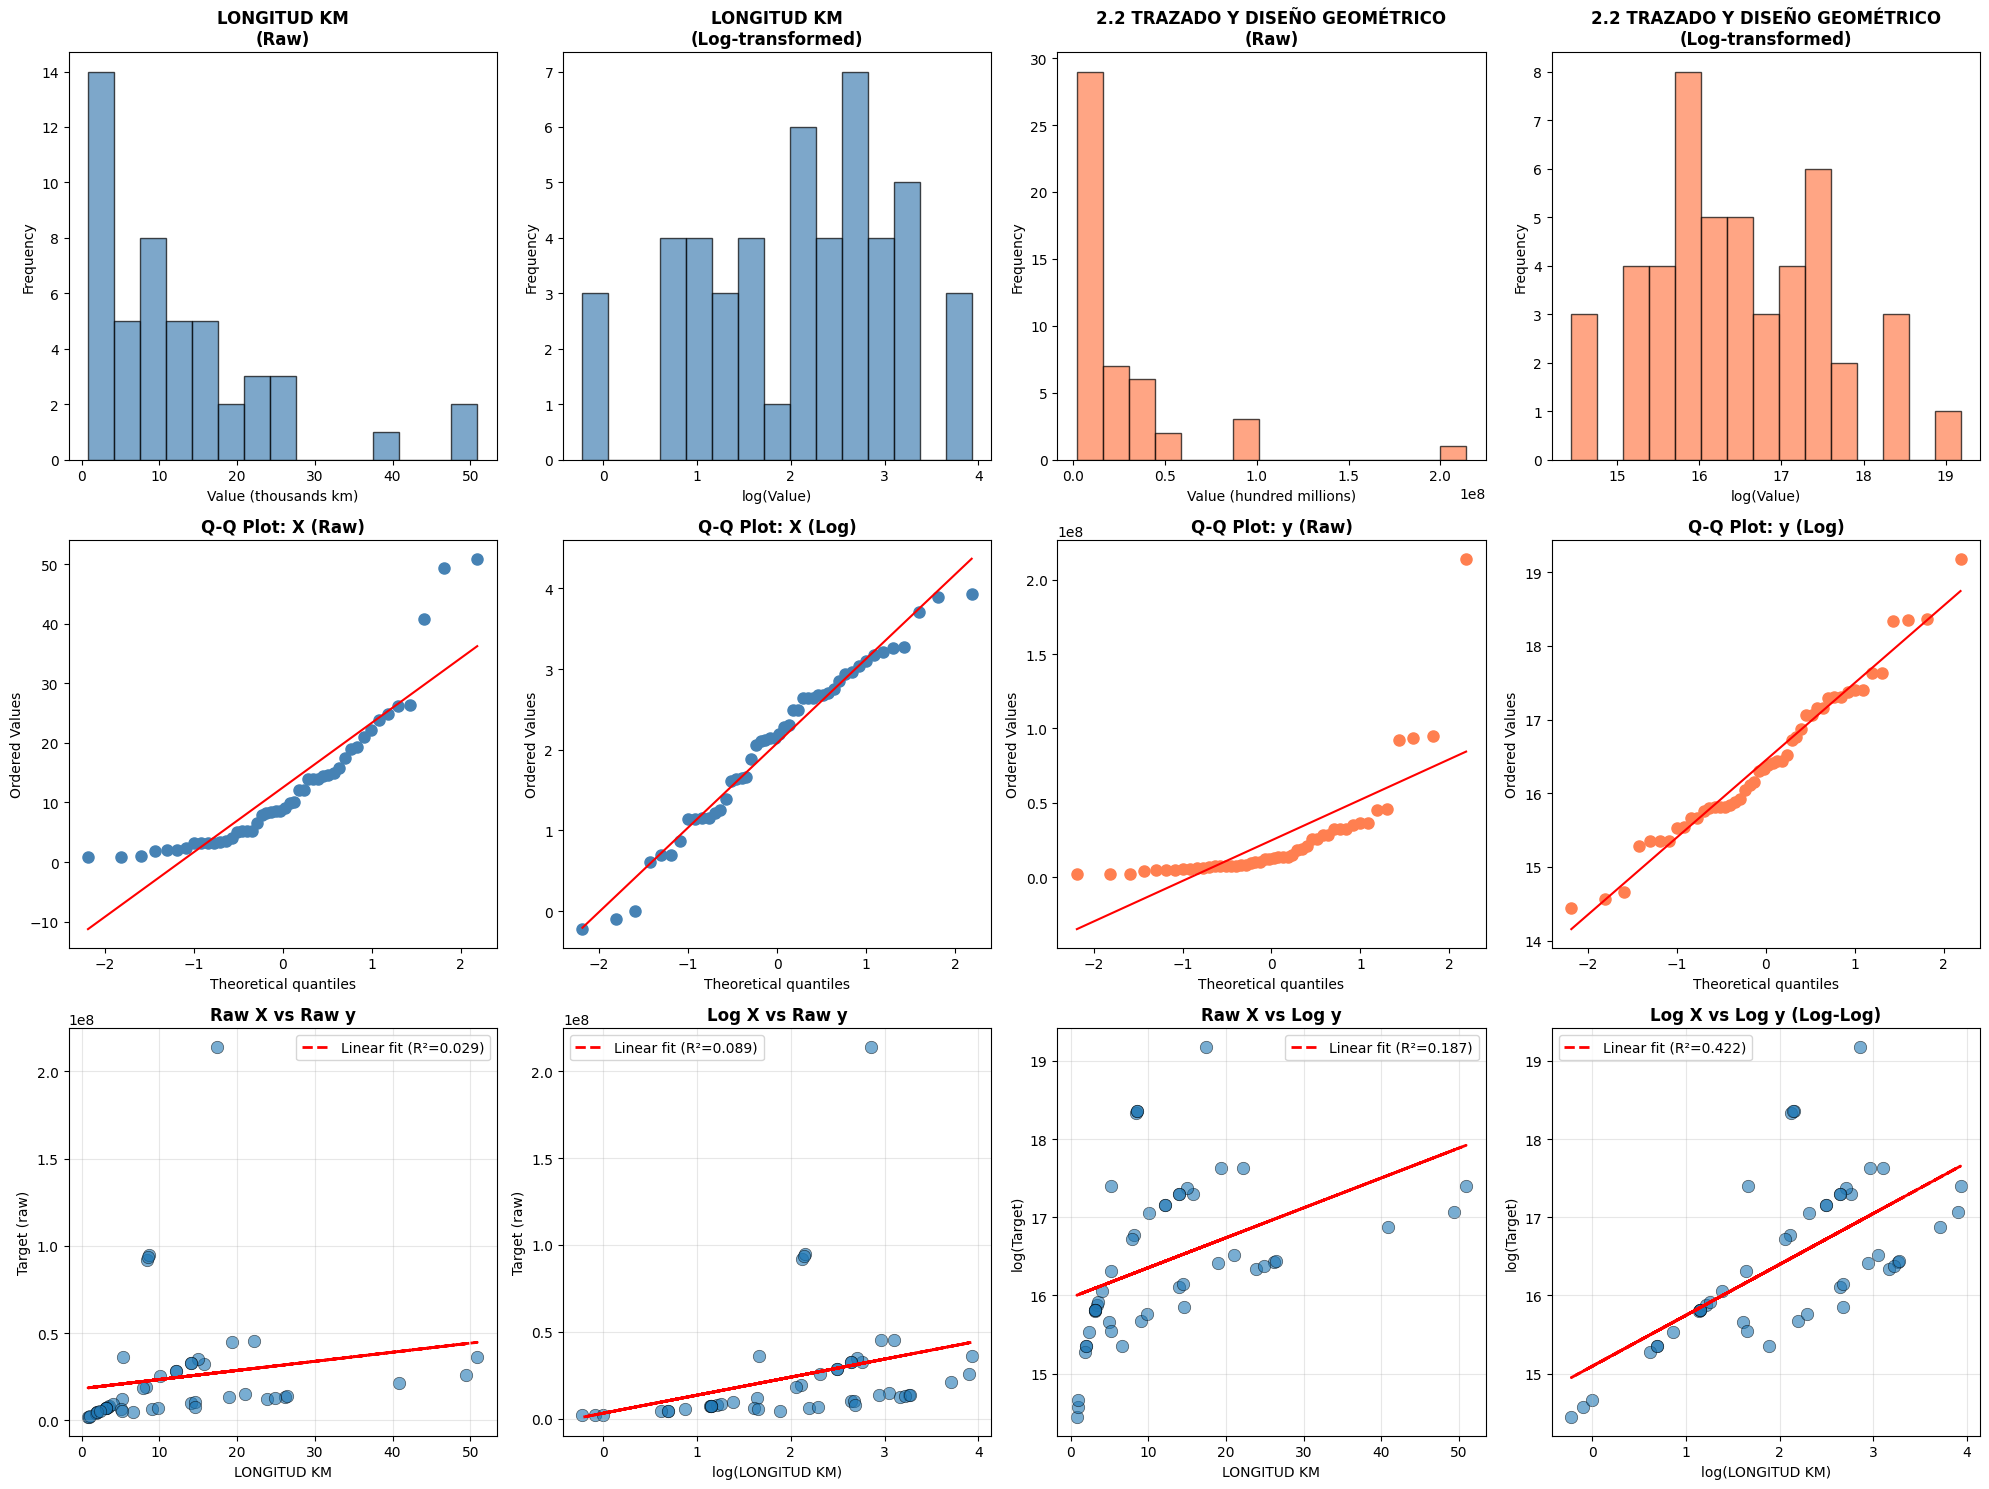

In [17]:
def plot_distribution_analysis(df_clean, predictor_name, target_name):
    """
    Visualize distributions and transformations
    """
    X_raw = df_clean[predictor_name].values
    y_raw = df_clean[target_name].values
    
    # Remove zeros for log
    mask = (X_raw > 0) & (y_raw > 0)
    X_raw = X_raw[mask]
    y_raw = y_raw[mask]
    
    X_log = np.log(X_raw)
    y_log = np.log(y_raw)
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    # Row 1: Histograms
    axes[0, 0].hist(X_raw, bins=15, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0, 0].set_title(f'{predictor_name}\n(Raw)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Value (thousands km)')
    axes[0, 0].set_ylabel('Frequency')
    
    axes[0, 1].hist(X_log, bins=15, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0, 1].set_title(f'{predictor_name}\n(Log-transformed)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('log(Value)')
    axes[0, 1].set_ylabel('Frequency')
    
    axes[0, 2].hist(y_raw, bins=15, alpha=0.7, color='coral', edgecolor='black')
    axes[0, 2].set_title(f'{target_name}\n(Raw)', fontsize=12, fontweight='bold')
    axes[0, 2].set_xlabel('Value (hundred millions)')
    axes[0, 2].set_ylabel('Frequency')
    
    axes[0, 3].hist(y_log, bins=15, alpha=0.7, color='coral', edgecolor='black')
    axes[0, 3].set_title(f'{target_name}\n(Log-transformed)', fontsize=12, fontweight='bold')
    axes[0, 3].set_xlabel('log(Value)')
    axes[0, 3].set_ylabel('Frequency')
    
    # Row 2: Q-Q plots (normality check)
    stats.probplot(X_raw, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot: X (Raw)', fontsize=12, fontweight='bold')
    axes[1, 0].get_lines()[0].set_color('steelblue')
    axes[1, 0].get_lines()[0].set_markersize(8)
    
    stats.probplot(X_log, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot: X (Log)', fontsize=12, fontweight='bold')
    axes[1, 1].get_lines()[0].set_color('steelblue')
    axes[1, 1].get_lines()[0].set_markersize(8)
    
    stats.probplot(y_raw, dist="norm", plot=axes[1, 2])
    axes[1, 2].set_title('Q-Q Plot: y (Raw)', fontsize=12, fontweight='bold')
    axes[1, 2].get_lines()[0].set_color('coral')
    axes[1, 2].get_lines()[0].set_markersize(8)
    
    stats.probplot(y_log, dist="norm", plot=axes[1, 3])
    axes[1, 3].set_title('Q-Q Plot: y (Log)', fontsize=12, fontweight='bold')
    axes[1, 3].get_lines()[0].set_color('coral')
    axes[1, 3].get_lines()[0].set_markersize(8)
    
    # Row 3: Scatter plots with different transformations
    def plot_relationship_with_residuals(ax, X, y, title, x_label, y_label):
        # Fit line
        model = LinearRegression()
        model.fit(X.reshape(-1, 1), y)
        y_pred = model.predict(X.reshape(-1, 1))
        r2 = model.score(X.reshape(-1, 1), y)
        
        # Plot
        ax.scatter(X, y, alpha=0.6, s=80, edgecolor='black', linewidth=0.5)
        ax.plot(X, y_pred, 'r--', linewidth=2, label=f'Linear fit (R²={r2:.3f})')
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plot_relationship_with_residuals(axes[2, 0], X_raw, y_raw, 
                                    'Raw X vs Raw y', 
                                    'LONGITUD KM', 'Target (raw)')
    
    plot_relationship_with_residuals(axes[2, 1], X_log, y_raw, 
                                    'Log X vs Raw y', 
                                    'log(LONGITUD KM)', 'Target (raw)')
    
    plot_relationship_with_residuals(axes[2, 2], X_raw, y_log, 
                                    'Raw X vs Log y', 
                                    'LONGITUD KM', 'log(Target)')
    
    plot_relationship_with_residuals(axes[2, 3], X_log, y_log, 
                                    'Log X vs Log y (Log-Log)', 
                                    'log(LONGITUD KM)', 'log(Target)')
    
    plt.tight_layout()
    plt.show()

plot_distribution_analysis(df_item_cleaned, predictor_name, target_name)


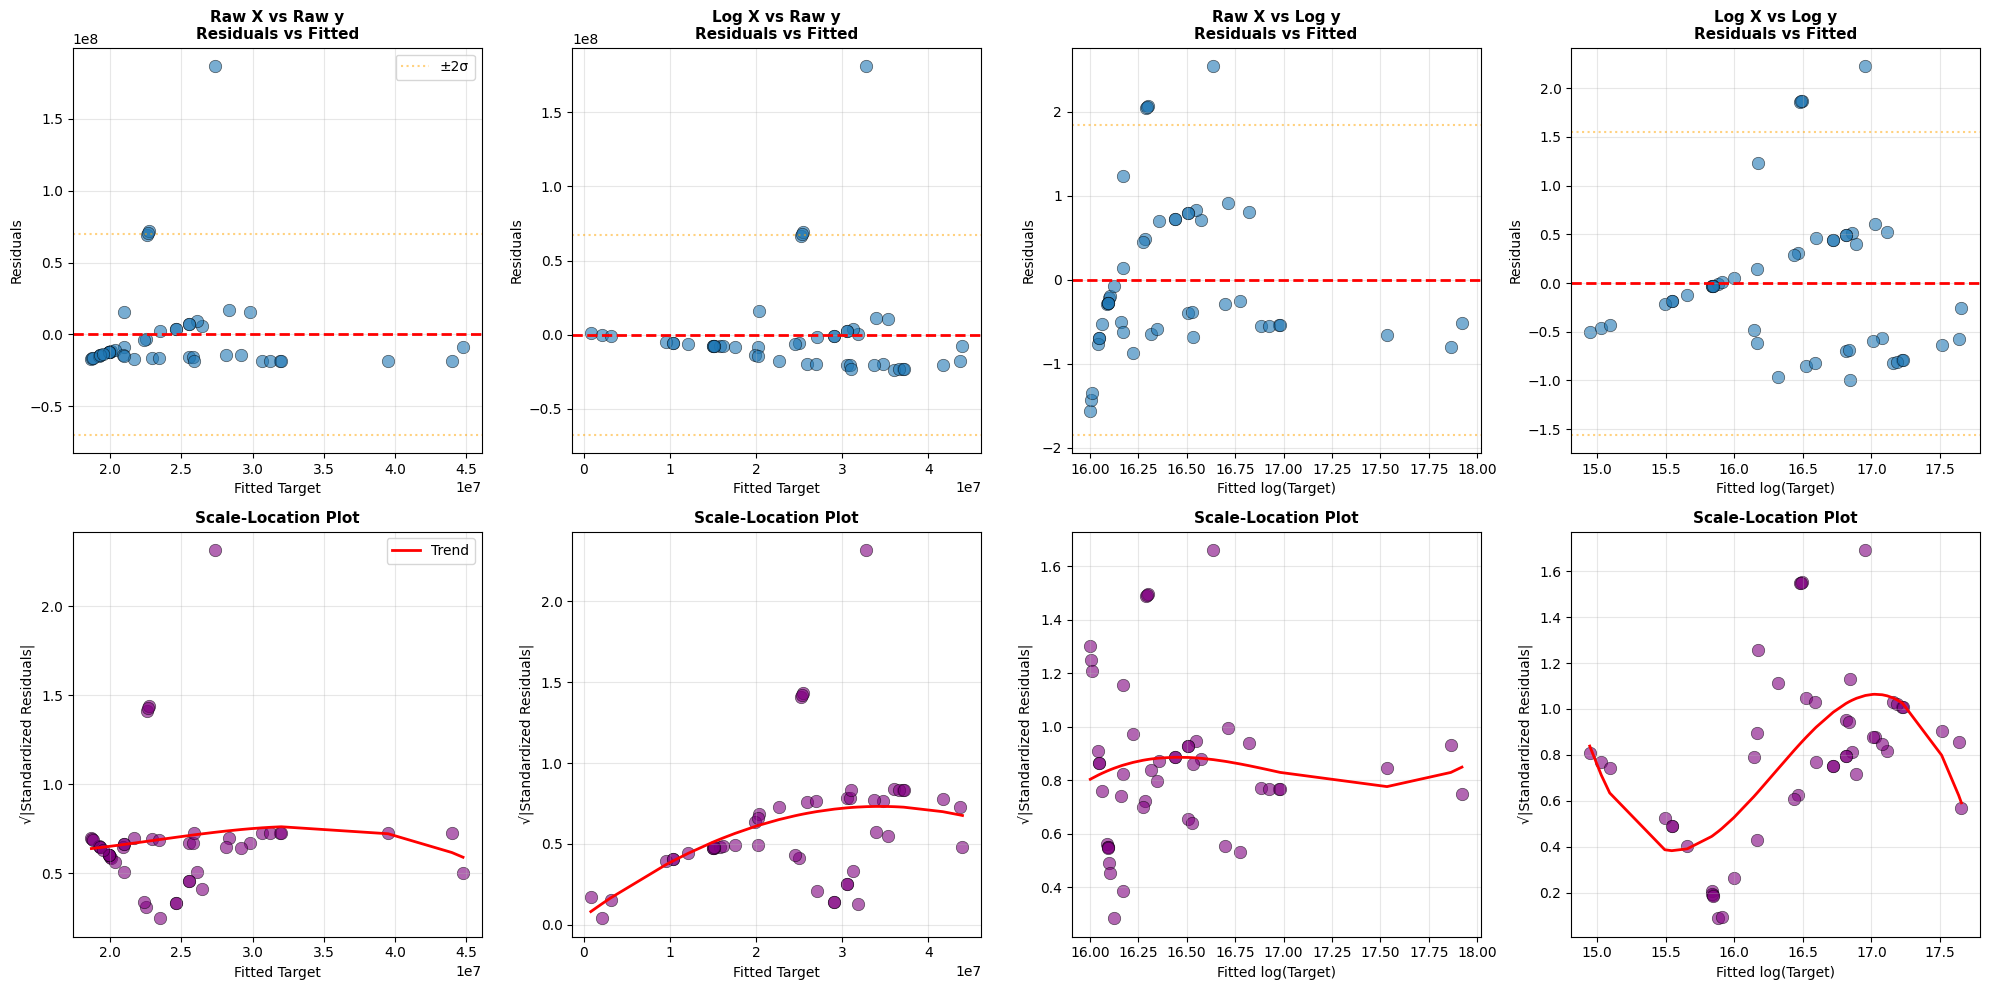


📖 HOW TO INTERPRET RESIDUAL PLOTS

1. Residuals vs Fitted (Top row):
   ✓ GOOD: Random scatter around 0 with constant spread
   ✗ BAD: Funnel shape (wider spread at one end) = Heteroscedasticity!
   ✗ BAD: Curved pattern = Non-linear relationship

2. Scale-Location Plot (Bottom row):
   ✓ GOOD: Flat horizontal red line = Homoscedastic
   ✗ BAD: Upward/downward trend = Heteroscedastic
   ✗ BAD: U-shape = Variance changes across range


In [ ]:
def plot_heteroscedasticity(df_clean, predictor_name, target_name):
    """
    Visualize heteroscedasticity through residual plots
    """
    X_raw = df_clean[predictor_name].values
    y_raw = df_clean[target_name].values
    
    # Remove zeros for log
    mask = (X_raw > 0) & (y_raw > 0)
    X_raw = X_raw[mask]
    y_raw = y_raw[mask]
    
    X_log = np.log(X_raw)
    y_log = np.log(y_raw)
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    transformations = [
        ("Raw X vs Raw y", X_raw, y_raw, "LONGITUD KM", "Target"),
        ("Log X vs Raw y", X_log, y_raw, "log(LONGITUD KM)", "Target"),
        ("Raw X vs Log y", X_raw, y_log, "LONGITUD KM", "log(Target)"),
        ("Log X vs Log y", X_log, y_log, "log(LONGITUD KM)", "log(Target)")
    ]
    
    for idx, (title, X, y, x_label, y_label) in enumerate(transformations):
        # Fit model
        model = LinearRegression()
        model.fit(X.reshape(-1, 1), y)
        y_pred = model.predict(X.reshape(-1, 1))
        residuals = y - y_pred
        
        # Top row: Residuals vs Fitted
        axes[0, idx].scatter(y_pred, residuals, alpha=0.6, s=80, edgecolor='black', linewidth=0.5)
        axes[0, idx].axhline(y=0, color='r', linestyle='--', linewidth=2)
        axes[0, idx].set_title(f'{title}\nResiduals vs Fitted', fontsize=11, fontweight='bold')
        axes[0, idx].set_xlabel(f'Fitted {y_label}')
        axes[0, idx].set_ylabel('Residuals')
        axes[0, idx].grid(True, alpha=0.3)
        
        # Add variance bands
        std_residuals = np.std(residuals)
        axes[0, idx].axhline(y=2*std_residuals, color='orange', linestyle=':', alpha=0.5, label='±2σ')
        axes[0, idx].axhline(y=-2*std_residuals, color='orange', linestyle=':', alpha=0.5)
        
        # Check for funnel shape (heteroscedasticity indicator)
        if idx == 0:
            axes[0, idx].legend()
        
        # Bottom row: Scale-Location plot (sqrt of standardized residuals)
        standardized_residuals = residuals / np.std(residuals)
        axes[1, idx].scatter(y_pred, np.sqrt(np.abs(standardized_residuals)), 
                           alpha=0.6, s=80, edgecolor='black', linewidth=0.5, color='purple')
        
        # Fit lowess smoother to show trend
        from scipy.interpolate import UnivariateSpline
        sorted_idx = np.argsort(y_pred)
        if len(y_pred) > 4:
            try:
                spline = UnivariateSpline(y_pred[sorted_idx], 
                                         np.sqrt(np.abs(standardized_residuals))[sorted_idx], 
                                         s=len(y_pred), k=min(3, len(y_pred)-1))
                axes[1, idx].plot(y_pred[sorted_idx], spline(y_pred[sorted_idx]), 
                                'r-', linewidth=2, label='Trend')
            except:
                pass
        
        axes[1, idx].set_title(f'Scale-Location Plot', fontsize=11, fontweight='bold')
        axes[1, idx].set_xlabel(f'Fitted {y_label}')
        axes[1, idx].set_ylabel('√|Standardized Residuals|')
        axes[1, idx].grid(True, alpha=0.3)
        
        if idx == 0:
            axes[1, idx].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("📖 HOW TO INTERPRET RESIDUAL PLOTS")
    print("="*80)
    print("\n1. Residuals vs Fitted (Top row):")
    print("   ✓ GOOD: Random scatter around 0 with constant spread")
    print("   ✗ BAD: Funnel shape (wider spread at one end) = Heteroscedasticity!")
    print("   ✗ BAD: Curved pattern = Non-linear relationship")
    
    print("\n2. Scale-Location Plot (Bottom row):")
    print("   ✓ GOOD: Flat horizontal red line = Homoscedastic")
    print("   ✗ BAD: Upward/downward trend = Heteroscedastic")
    print("   ✗ BAD: U-shape = Variance changes across range")
    print("="*80)

plot_heteroscedasticity(df_item_cleaned, predictor_name, target_name)


## 📋 FINAL RECOMMENDATIONS SUMMARY

### 1️⃣ **Standardization/Normalization: YES!**
- Your predictor (LONGITUD KM) is in **thousands**
- Your target is in **hundreds of millions** 
- Scale difference: ~100,000x
- **Use StandardScaler** (already in your pipeline ✓)

### 2️⃣ **Log Transformation Decision**
Based on the analysis above, choose the transformation with:
- **Highest R²** in the relationship analysis
- **Lowest heteroscedasticity** (R² < 0.1 in Breusch-Pagan test)
- **Most normal distributions** (Q-Q plots closer to diagonal line)

**Common patterns:**
- If **Log X vs Log Y** wins → Use log-log transformation (power law relationship)
- If **Raw X vs Log Y** wins → Only transform target
- If **Log X vs Raw Y** wins → Only transform input
- If **Raw X vs Raw Y** wins → No transformation needed

### 3️⃣ **Heteroscedasticity Fixes**

If heteroscedasticity is detected:
1. **Log transform** the variable causing it (usually helps!)
2. Use **Weighted Least Squares** (WLS) instead of OLS
3. Use **robust standard errors**
4. Try **quantile regression** instead of mean regression

### 4️⃣ **Implementation in Your Model**

**If log-log is best:**
```python
# Already in your code!
X[predictor_name + ' LOG'] = np.log1p(X[predictor_name])
model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)
```

**If only log(y) is best:**
```python
# Don't add LOG feature to X
X = df_clean[[predictor_name, hue_name]].copy()  # No LOG column
# But still transform target
model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)
```

**If only log(X) is best:**
```python
# Add LOG feature
X[predictor_name + ' LOG'] = np.log1p(X[predictor_name])
# Don't transform target
model = pipe  # No TransformedTargetRegressor
```

**If no transformation needed:**
```python
X = df_clean[[predictor_name, hue_name]].copy()
model = pipe  # Raw features, raw target
```


📊 CATEGORICAL VARIABLE ANALYSIS: ALCANCE

Construcción :
  Sample size: 7
  R² (linear fit): 1.0000
  Mean LONGITUD KM: 29.44
  Mean 2.2 TRAZADO Y DISEÑO GEOMÉTRICO: 15,369,606
  Slope: 522,014.75

Mejoramiento:
  Sample size: 13
  R² (linear fit): 0.0306
  Mean LONGITUD KM: 14.44
  Mean 2.2 TRAZADO Y DISEÑO GEOMÉTRICO: 30,046,009
  Slope: 806,750.12

Puesta a punto:
  Sample size: 8
  R² (linear fit): 1.0000
  Mean LONGITUD KM: 11.09
  Mean 2.2 TRAZADO Y DISEÑO GEOMÉTRICO: 25,906,401
  Slope: 2,337,068.16

Rehabilitación:
  Sample size: 5
  R² (linear fit): 0.0273
  Mean LONGITUD KM: 8.72
  Mean 2.2 TRAZADO Y DISEÑO GEOMÉTRICO: 64,515,738
  Slope: 1,601,837.45

Segunda calzada:
  Sample size: 13
  R² (linear fit): 0.9992
  Mean LONGITUD KM: 5.34
  Mean 2.2 TRAZADO Y DISEÑO GEOMÉTRICO: 11,656,002
  Slope: 2,013,265.09


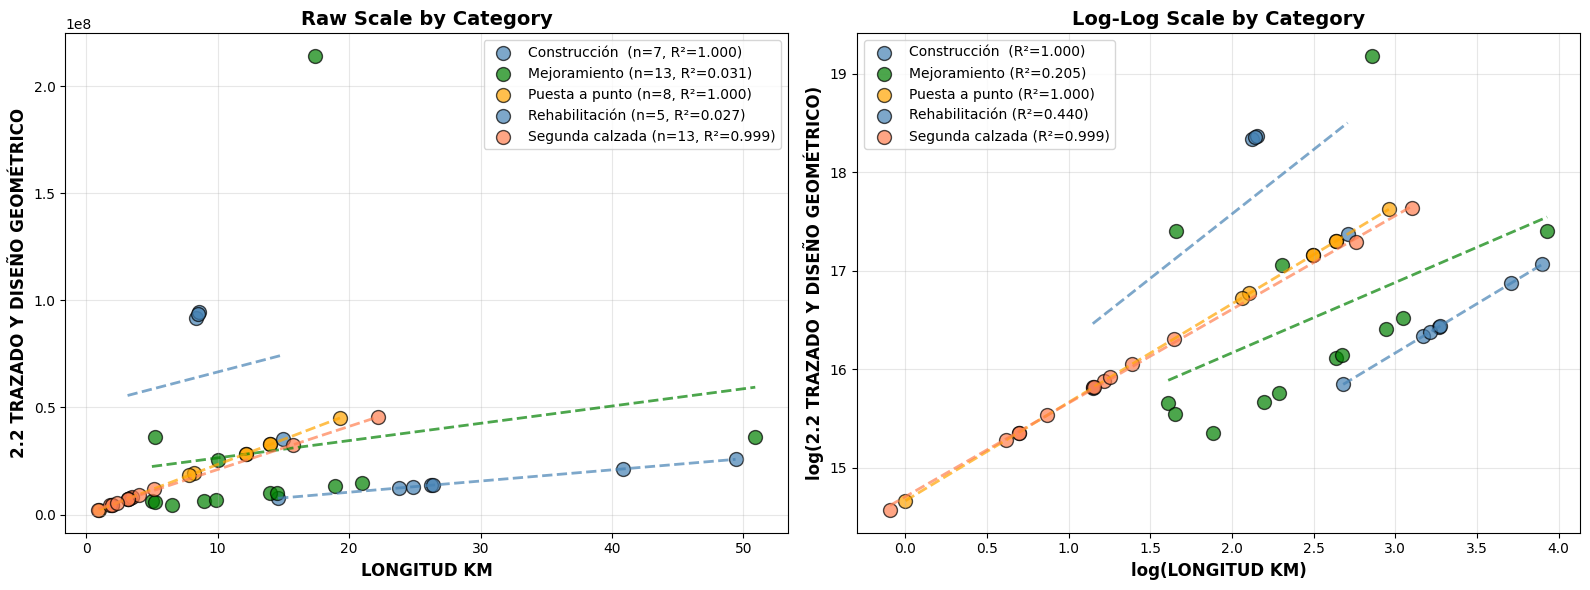


💡 INTERPRETATION:
- If categories have DIFFERENT slopes → Categorical variable is important!
- If categories have SIMILAR slopes but different intercepts → Still important
- If all lines overlap → Categorical variable may not add much value
- Small sample sizes per category → Results less reliable


In [20]:
def analyze_categorical_effect(df_clean, predictor_name, hue_name, target_name):
    """
    Check if different categories have different relationships
    """
    X = df_clean[predictor_name].values
    y = df_clean[target_name].values
    categories = df_clean[hue_name].values
    
    # Remove zeros
    mask = (X > 0) & (y > 0)
    X = X[mask]
    y = y[mask]
    categories = categories[mask]
    
    unique_cats = np.unique(categories)
    
    print("="*80)
    print(f"📊 CATEGORICAL VARIABLE ANALYSIS: {hue_name}")
    print("="*80)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Raw scale
    colors = ['steelblue', 'coral', 'green', 'purple', 'orange']
    for idx, cat in enumerate(unique_cats):
        mask_cat = categories == cat
        X_cat = X[mask_cat]
        y_cat = y[mask_cat]
        
        # Fit linear model for this category
        if len(X_cat) > 1:
            model = LinearRegression()
            model.fit(X_cat.reshape(-1, 1), y_cat)
            r2 = model.score(X_cat.reshape(-1, 1), y_cat)
            
            # Plot
            axes[0].scatter(X_cat, y_cat, label=f'{cat} (n={len(X_cat)}, R²={r2:.3f})', 
                          s=100, alpha=0.7, color=colors[idx % len(colors)], edgecolor='black', linewidth=1)
            
            # Add trend line
            X_line = np.linspace(X_cat.min(), X_cat.max(), 100)
            y_line = model.predict(X_line.reshape(-1, 1))
            axes[0].plot(X_line, y_line, '--', color=colors[idx % len(colors)], linewidth=2, alpha=0.7)
            
            print(f"\n{cat}:")
            print(f"  Sample size: {len(X_cat)}")
            print(f"  R² (linear fit): {r2:.4f}")
            print(f"  Mean {predictor_name}: {X_cat.mean():.2f}")
            print(f"  Mean {target_name}: {y_cat.mean():,.0f}")
            print(f"  Slope: {model.coef_[0]:,.2f}")
    
    axes[0].set_xlabel(predictor_name, fontsize=12, fontweight='bold')
    axes[0].set_ylabel(target_name, fontsize=12, fontweight='bold')
    axes[0].set_title('Raw Scale by Category', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Log-log scale
    X_log = np.log(X)
    y_log = np.log(y)
    
    for idx, cat in enumerate(unique_cats):
        mask_cat = categories == cat
        X_cat = X_log[mask_cat]
        y_cat = y_log[mask_cat]
        
        if len(X_cat) > 1:
            model = LinearRegression()
            model.fit(X_cat.reshape(-1, 1), y_cat)
            r2 = model.score(X_cat.reshape(-1, 1), y_cat)
            
            axes[1].scatter(X_cat, y_cat, label=f'{cat} (R²={r2:.3f})', 
                          s=100, alpha=0.7, color=colors[idx % len(colors)], edgecolor='black', linewidth=1)
            
            X_line = np.linspace(X_cat.min(), X_cat.max(), 100)
            y_line = model.predict(X_line.reshape(-1, 1))
            axes[1].plot(X_line, y_line, '--', color=colors[idx % len(colors)], linewidth=2, alpha=0.7)
    
    axes[1].set_xlabel(f'log({predictor_name})', fontsize=12, fontweight='bold')
    axes[1].set_ylabel(f'log({target_name})', fontsize=12, fontweight='bold')
    axes[1].set_title('Log-Log Scale by Category', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("💡 INTERPRETATION:")
    print("="*80)
    print("- If categories have DIFFERENT slopes → Categorical variable is important!")
    print("- If categories have SIMILAR slopes but different intercepts → Still important")
    print("- If all lines overlap → Categorical variable may not add much value")
    print("- Small sample sizes per category → Results less reliable")
    print("="*80)

analyze_categorical_effect(df_item_cleaned, predictor_name, hue_name, target_name)


---

# 🎓 KEY TAKEAWAYS FROM YOUR DATA EXPLORATION

## Your Questions Answered:

### ❓ "Should I use log-log, log input, log target, or nothing?"
**Answer:** Check Cell 6 output - look for the transformation with:
- Highest R² in "RELATIONSHIP ANALYSIS" 
- Lowest R² in "HETEROSCEDASTICITY ANALYSIS" (< 0.1 is good)
- The winner tells you which transformation to use!

### ❓ "How do I measure heteroscedasticity?"
**Answer:** Cell 6 shows **Breusch-Pagan test** results:
- R² between residuals² and X
- R² < 0.1 → Homoscedastic (good!) ✓
- R² > 0.3 → Heteroscedastic (problem!) ✗
- Also check **variance ratio** (should be near 1.0)

**Visual check:** Cell 8 residual plots:
- Funnel shape = heteroscedasticity
- Flat scatter = homoscedasticity

### ❓ "Do I need standardization/normalization?"
**Answer:** **YES!** Cell 6 shows your scale difference.
- Already using StandardScaler in your pipeline ✓
- This is correct - keep it!

### ❓ "How to transform/fix heteroscedasticity?"
**Answer:** 
1. **Best fix:** Use the log transformation that minimizes heteroscedasticity
2. **Alternative:** Use Weighted Least Squares (WLS)
3. **For robust errors:** Use sklearn's `QuantileRegressor`

---

## 📊 Decision Tree for Transformations:

```
START: Look at Cell 6 "Best transformation" result
│
├─ If "Log X vs Log Y" has highest R² and lowest heteroscedasticity
│  └─> USE: Both log transforms (what you're doing now!)
│      X['LOG'] = np.log1p(X_raw)
│      TransformedTargetRegressor(func=np.log1p)
│
├─ If "Raw X vs Log Y" is best
│  └─> USE: Only transform target
│      X = X_raw (no LOG column)
│      TransformedTargetRegressor(func=np.log1p)
│
├─ If "Log X vs Raw Y" is best
│  └─> USE: Only transform input
│      X['LOG'] = np.log1p(X_raw)
│      model = pipe (no TransformedTargetRegressor)
│
└─ If "Raw X vs Raw Y" is best
   └─> USE: No transformations
       X = X_raw
       model = pipe
```

---

## 🔍 Next Steps:

1. **Review all outputs** from cells 5-10
2. **Identify the winning transformation** from Cell 6
3. **Check residual plots** in Cell 8 - do they look better after transformation?
4. **Consider categorical importance** from Cell 10 - is ALCANCE adding value?
5. **Update your model** based on findings
6. **Re-run with Cross-Validation** to get stable performance metrics


In [4]:
def train_model_cv(df_clean, predictor_name, hue_name, target_name):
    """
    Train model with Repeated K-Fold Cross-Validation optimized for small datasets.
    Uses 3-fold or 4-fold repeated multiple times for stability.
    """
    X = df_clean[[predictor_name, hue_name]].copy()
    X[predictor_name + ' LOG'] = np.log1p(X[predictor_name])
    y = df_clean[target_name].astype(float)

    # Preprocessing pipeline
    pre = ColumnTransformer([
        ('num', StandardScaler(), [predictor_name, predictor_name + ' LOG']),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), [hue_name])
    ])

    svr = SVR(kernel='rbf')
    pipe = Pipeline([('pre', pre), ('svr', svr)])
    model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)

    param_grid = {
        'regressor__svr__C': [10, 100, 300, 1000],
        'regressor__svr__epsilon': [0.1, 0.3, 0.5, 1.0],
        'regressor__svr__gamma': ['scale', 'auto', 0.1, 0.01],
    }

    # For small datasets: use 3-fold or 4-fold repeated many times
    # This ensures multiple samples per test set (needed for R²) while being thorough
    n_samples = len(X)
    n_splits = min(4, n_samples)  # Use 3-4 folds for small datasets
    n_repeats = 10  # Repeat 10 times for stability (total: 30-40 iterations)
    
    outer_cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    
    # Inner loop: GridSearchCV for hyperparameter tuning (use fewer folds to avoid issues)
    inner_cv_folds = min(3, n_samples)
    gs = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', 
                      cv=inner_cv_folds, n_jobs=-1, refit=True)
    
    # Custom MAPE scorer
    def mape_score(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, np.nan, y_true))) * 100
    
    mape_scorer = make_scorer(mape_score, greater_is_better=False)
    
    # Perform nested cross-validation
    scoring = {
        'r2': 'r2',
        'mae': 'neg_mean_absolute_error',
        'rmse': 'neg_root_mean_squared_error',
        'mape': mape_scorer
    }
    
    print(f"Dataset size: {n_samples} samples")
    print(f"Using Repeated {n_splits}-Fold CV with {n_repeats} repeats = {n_splits * n_repeats} total iterations")
    
    cv_results = cross_validate(gs, X, y, cv=outer_cv, scoring=scoring, 
                                n_jobs=-1, return_train_score=True)
    
    # Calculate statistics across all folds
    results = {
        'Test_R2_mean': cv_results['test_r2'].mean(),
        'Test_R2_std': cv_results['test_r2'].std(),
        'Test_MAE_mean': -cv_results['test_mae'].mean(),
        'Test_MAE_std': cv_results['test_mae'].std(),
        'Test_RMSE_mean': -cv_results['test_rmse'].mean(),
        'Test_RMSE_std': cv_results['test_rmse'].std(),
        'Test_MAPE_mean': -cv_results['test_mape'].mean(),
        'Test_MAPE_std': cv_results['test_mape'].std(),
        'Train_R2_mean': cv_results['train_r2'].mean(),
        'Train_R2_std': cv_results['train_r2'].std(),
    }
    
    print(f"\n{'='*60}")
    print(f"REPEATED K-FOLD CROSS-VALIDATION RESULTS")
    print(f"Total iterations: {n_splits * n_repeats}")
    print(f"{'='*60}")
    print(f"Test R²:     {results['Test_R2_mean']:.4f} ± {results['Test_R2_std']:.4f}")
    print(f"Test MAE:    {results['Test_MAE_mean']:.2f} ± {results['Test_MAE_std']:.2f}")
    print(f"Test RMSE:   {results['Test_RMSE_mean']:.2f} ± {results['Test_RMSE_std']:.2f}")
    print(f"Test MAPE:   {results['Test_MAPE_mean']:.2f}% ± {results['Test_MAPE_std']:.2f}%")
    print(f"Train R²:    {results['Train_R2_mean']:.4f} ± {results['Train_R2_std']:.4f}")
    print(f"{'='*60}\n")
    
    # Train final model on all data to get best hyperparameters
    gs.fit(X, y)
    print(f'Best hyperparameters (from all data): {gs.best_params_}\n')
    
    # Plot CV results distribution
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # R² distribution
    axes[0, 0].hist(cv_results['test_r2'], bins=15, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0, 0].axvline(results['Test_R2_mean'], color='red', linestyle='--', linewidth=2, label=f"Mean: {results['Test_R2_mean']:.3f}")
    axes[0, 0].set_title(f'Test R² Distribution ({n_splits}-Fold × {n_repeats} repeats)')
    axes[0, 0].set_xlabel('R²')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    
    # MAE distribution
    axes[0, 1].hist(-cv_results['test_mae'], bins=15, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].axvline(results['Test_MAE_mean'], color='red', linestyle='--', linewidth=2, label=f"Mean: {results['Test_MAE_mean']:.0f}")
    axes[0, 1].set_title(f'Test MAE Distribution ({n_splits}-Fold × {n_repeats} repeats)')
    axes[0, 1].set_xlabel('MAE')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    
    # RMSE distribution
    axes[1, 0].hist(-cv_results['test_rmse'], bins=15, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 0].axvline(results['Test_RMSE_mean'], color='red', linestyle='--', linewidth=2, label=f"Mean: {results['Test_RMSE_mean']:.0f}")
    axes[1, 0].set_title(f'Test RMSE Distribution ({n_splits}-Fold × {n_repeats} repeats)')
    axes[1, 0].set_xlabel('RMSE')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    
    # Train vs Test R² comparison
    axes[1, 1].boxplot([cv_results['train_r2'], cv_results['test_r2']], 
                       labels=['Train', 'Test'], patch_artist=True)
    axes[1, 1].set_title('Train vs Test R² (Overfitting Check)')
    axes[1, 1].set_ylabel('R²')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return gs, results, cv_results


## Cross-Validation Approach for Robust Results (Small Datasets)

The new `train_model_cv()` function uses **Repeated K-Fold Cross-Validation optimized for small datasets (<50 samples)**:

1. **Stable metrics**: Mean ± Standard Deviation across ~40 CV iterations (4-Fold × 10 repeats)
2. **Confidence intervals**: Shows the range of performance you can expect
3. **Overfitting detection**: Compares train vs test performance
4. **Distribution visualization**: See how metrics vary across folds

**Key differences from the original approach:**
- **Original**: Single train-test split → results depend heavily on random_state
- **New CV approach**: 40 splits averaged → stable results independent of random_state

**Why not Leave-One-Out CV?**
- LOOCV has only 1 sample per test set → R² cannot be calculated (returns NaN)
- Repeated 3-4 Fold CV keeps multiple samples per test set while still being thorough


## 🛠️ Solutions for Small Datasets (<50 samples)

### Strategy 1: Simplify the Model (RECOMMENDED)
Try simpler, more regularized models that work better with limited data:


In [ ]:


def train_simple_models_cv(df_clean, predictor_name, hue_name, target_name):
    """
    Compare multiple simple models for small datasets.
    Tests: Ridge, Lasso, ElasticNet, Random Forest, and Simplified SVR
    """
    X = df_clean[[predictor_name, hue_name]].copy()
    # X[predictor_name + ' LOG'] = np.log1p(X[predictor_name])
    y = df_clean[target_name].astype(float)

    # Preprocessing pipeline
    pre = ColumnTransformer([
        # ('num', StandardScaler(), [predictor_name, predictor_name + ' LOG']),
        ('num', StandardScaler(), [predictor_name, predictor_name]),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), [hue_name])
    ])

    # Cross-validation setup
    n_samples = len(X)
    n_splits = min(4, n_samples)
    n_repeats = 10
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    
    # Define multiple models to test
    models = {
        'Ridge': Pipeline([
            ('pre', pre),
            ('reg', TransformedTargetRegressor(
                regressor=Ridge(alpha=10.0),
                func=np.log1p, 
                inverse_func=np.expm1
            ))
        ]),
        'Lasso': Pipeline([
            ('pre', pre),
            ('reg', TransformedTargetRegressor(
                regressor=Lasso(alpha=1000.0, max_iter=10000),
                func=np.log1p, 
                inverse_func=np.expm1
            ))
        ]),
        'ElasticNet': Pipeline([
            ('pre', pre),
            ('reg', TransformedTargetRegressor(
                regressor=ElasticNet(alpha=1000.0, l1_ratio=0.5, max_iter=10000),
                func=np.log1p, 
                inverse_func=np.expm1
            ))
        ]),
        'SimpleSVR': Pipeline([
            ('pre', pre),
            ('reg', TransformedTargetRegressor(
                regressor=SVR(kernel='rbf', C=10, epsilon=0.5, gamma='scale'),  # Conservative params
                func=np.log1p, 
                inverse_func=np.expm1
            ))
        ]),
        'RandomForest': Pipeline([
            ('pre', pre),
            ('reg', TransformedTargetRegressor(
                regressor=RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42),
                func=np.log1p, 
                inverse_func=np.expm1
            ))
        ])
    }
    
    # Test each model
    print(f"Dataset size: {n_samples} samples")
    print(f"Testing {len(models)} models with {n_splits}-Fold × {n_repeats} repeats CV\n")
    
    all_results = {}
    
    for name, model in models.items():
        scoring = {
            'r2': 'r2',
            'mae': 'neg_mean_absolute_error',
            'rmse': 'neg_root_mean_squared_error'
        }
        
        cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, 
                                    n_jobs=-1, return_train_score=True)
        
        all_results[name] = {
            'test_r2_mean': cv_results['test_r2'].mean(),
            'test_r2_std': cv_results['test_r2'].std(),
            'test_mae_mean': -cv_results['test_mae'].mean(),
            'test_mae_std': cv_results['test_mae'].std(),
            'train_r2_mean': cv_results['train_r2'].mean(),
        }
    
    # Display comparison table
    print("="*80)
    print(f"{'Model':<15} {'Test R²':<20} {'Test MAE':<25} {'Train R²':<10} {'Overfit?':<10}")
    print("="*80)
    
    for name, res in all_results.items():
        overfit = "⚠️ YES" if (res['train_r2_mean'] - res['test_r2_mean']) > 0.2 else "✓ No"
        print(f"{name:<15} {res['test_r2_mean']:>6.3f} ± {res['test_r2_std']:<7.3f}   "
              f"{res['test_mae_mean']:>12,.0f} ± {res['test_mae_std']:<10,.0f}  "
              f"{res['train_r2_mean']:>6.3f}     {overfit}")
    
    print("="*80)
    
    # Find best model
    best_model_name = max(all_results, key=lambda k: all_results[k]['test_r2_mean'])
    print(f"\n🏆 Best model: {best_model_name} (highest Test R²)")
    print(f"   Test R² = {all_results[best_model_name]['test_r2_mean']:.3f} ± {all_results[best_model_name]['test_r2_std']:.3f}")
    
    return models[best_model_name], all_results


### Strategy 2: Fix Your SVR (if you must use it)

If you need to stick with SVR, reduce the parameter search space dramatically:

**Current problem:**
```python
param_grid = {
    'regressor__svr__C': [10, 100, 300, 1000],        # Too aggressive
    'regressor__svr__epsilon': [0.1, 0.3, 0.5, 1.0],  
    'regressor__svr__gamma': ['scale', 'auto', 0.1, 0.01],
}
```

**Better for small datasets:**
```python
param_grid = {
    'regressor__svr__C': [1, 10],              # Lower C = more regularization
    'regressor__svr__epsilon': [0.5, 1.0],     # Higher epsilon = simpler model
    'regressor__svr__gamma': ['scale'],        # Just use 'scale'
}
```

Or even better: **Use fixed conservative parameters, no grid search:**
```python
svr = SVR(kernel='rbf', C=10, epsilon=0.5, gamma='scale')
```



### Strategy 3: Other Improvements

1. **Check your data for issues:**
   - Are there extreme outliers in the target variable?
   - Is the relationship actually linear or complex?
   - Plot `LONGITUD KM` vs target to see the pattern

2. **Feature engineering:**
   - Try using ONLY `LONGITUD KM` (drop LOG version and categorical)
   - Or ONLY `LONGITUD KM LOG`
   - Sometimes simpler features work better with small datasets

3. **Ensemble averaging:**
   - Train multiple simple models and average their predictions
   - More stable than a single complex model

4. **Accept the limitations:**
   - With only 26 samples, you may not be able to get great predictive performance
   - Report confidence intervals (± values) to show uncertainty
   - Focus on interpreting which features matter rather than perfect predictions

### 📊 What "Good" Results Look Like

For 26 samples, realistic expectations:
- **Test R² = 0.30 to 0.60** would be decent
- **Train R² - Test R² < 0.15** (no significant overfitting)
- **Low std deviation** on metrics (< 0.20 for R²)

Your current results (Test R² = -97) mean the model is essentially useless for prediction.


*********2.2 TRAZADO Y DISEÑO GEOMÉTRICO*********
Dataset size: 48 samples
Dataset size: 48 samples
Using Repeated 4-Fold CV with 10 repeats = 40 total iterations

REPEATED K-FOLD CROSS-VALIDATION RESULTS
Total iterations: 40
Test R²:     -0.4949 ± 1.5697
Test MAE:    17312664.25 ± 7272014.43
Test RMSE:   31942662.36 ± 17532625.07
Test MAPE:   81.41% ± 25.58%
Train R²:    0.1522 ± 0.1407

Best hyperparameters (from all data): {'regressor__svr__C': 10, 'regressor__svr__epsilon': 1.0, 'regressor__svr__gamma': 0.01}



C:\Users\forer\AppData\Local\Temp\ipykernel_25544\4126342082.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([cv_results['train_r2'], cv_results['test_r2']],


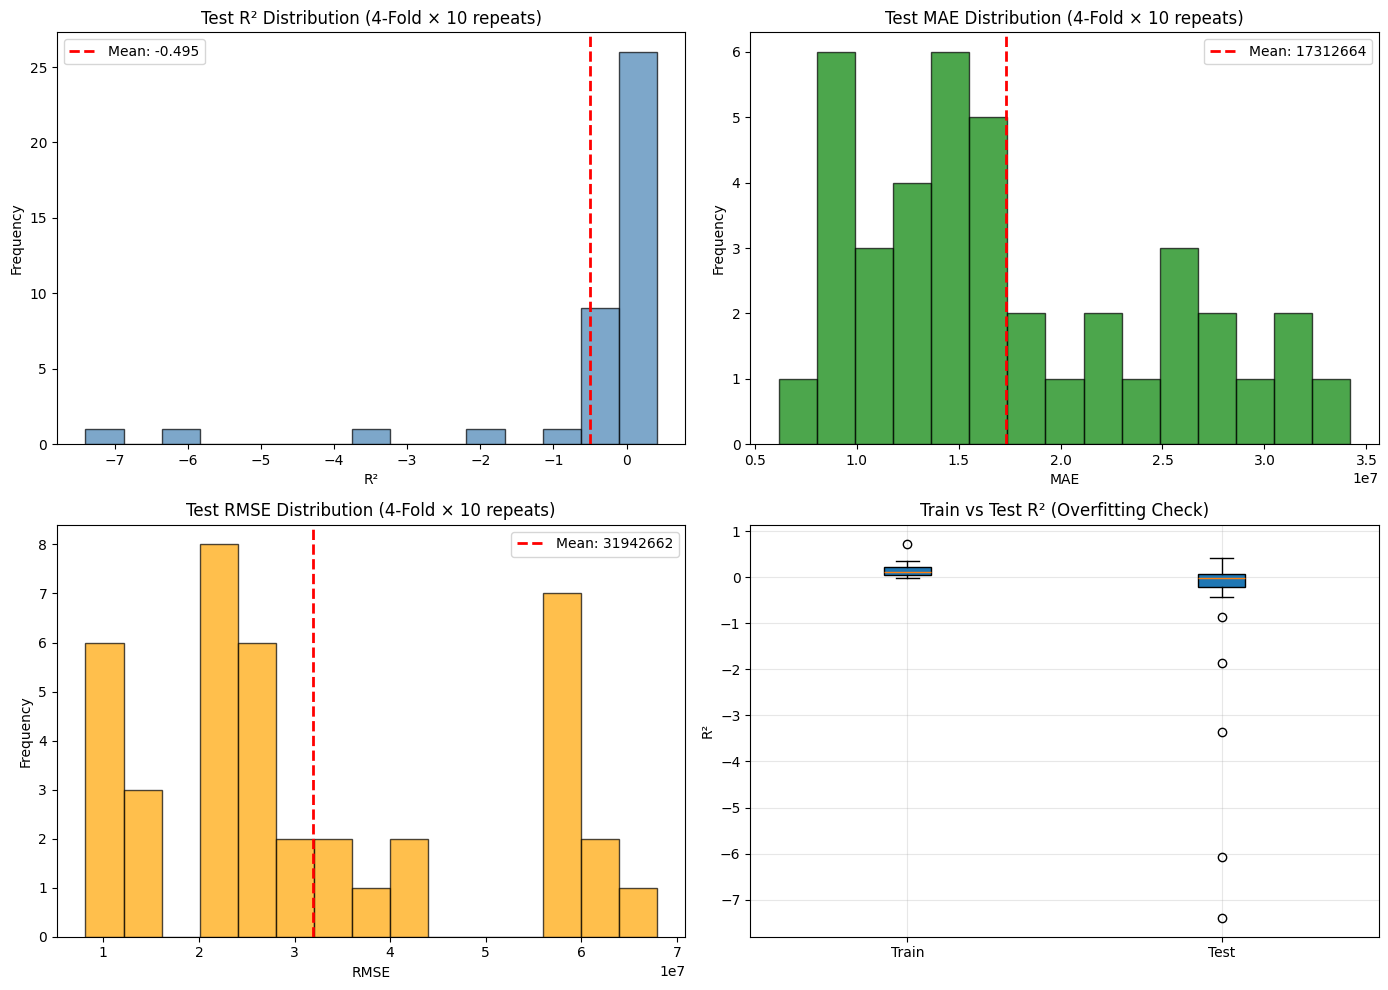

In [ ]:
predictor_name = 'LONGITUD KM'
hue_name = 'ALCANCE'
target_name = '2.2 TRAZADO Y DISEÑO GEOMÉTRICO'
# target_name = '2.4 - SISTEMAS INTELIGENTES'

df_item = df.loc[:, [predictor_name, hue_name, target_name]]
df_item_cleaned = remove_outliers(df_item, target_name)

print(f'*********{target_name}*********')
print(f'Dataset size: {len(df_item_cleaned)} samples')

# Use Leave-One-Out CV for robust evaluation with small datasets
model, results, cv_results = train_model_cv(
    df_item_cleaned, 
    predictor_name, 
    hue_name, 
    target_name
)


## Additional Strategies for Small Datasets

### 1. **Leave-One-Out Cross-Validation (LOOCV)**
For very small datasets (<50 samples), consider LOOCV:
```python
from sklearn.model_selection import LeaveOneOut
outer_cv = LeaveOneOut()  # Each sample is used once as test set
```

### 2. **Stratified Sampling**
If your target has different ranges, use stratified splits to ensure balanced folds:
```python
from sklearn.model_selection import StratifiedKFold
# Bin continuous target into categories for stratification
y_bins = pd.qcut(y, q=3, labels=False, duplicates='drop')
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
```

### 3. **Bootstrap Aggregation**
Average predictions from models trained on bootstrap samples:
```python
from sklearn.ensemble import BaggingRegressor
bagged_model = BaggingRegressor(gs, n_estimators=50, random_state=42)
```

### 4. **Reduce Model Complexity**
With small datasets, simpler models often generalize better:
- Reduce parameter grid size
- Use regularization (SVR's C parameter)
- Try Ridge/Lasso regression as alternatives

### 5. **Report Confidence Intervals**
Always report metrics as: `Mean ± Std` to show expected variation


In [ ]:
def compare_random_states(df_clean, predictor_name, hue_name, target_name, n_iterations=10):
    """
    Shows how metrics vary with different random_state values (original approach)
    vs. stability of CV approach
    """
    print("="*70)
    print("COMPARISON: Single Split (Original) vs Cross-Validation")
    print("="*70)
    
    # Test original approach with different random states
    r2_scores = []
    mae_scores = []
    
    print("\nOriginal approach with different random_state values:")
    for rs in range(42, 42 + n_iterations):
        X = df_clean[[predictor_name, hue_name]].copy()
        X[predictor_name + ' LOG'] = np.log1p(X[predictor_name])
        y = df_clean[target_name].astype(float)
        
        pre = ColumnTransformer([
            ('num', StandardScaler(), [predictor_name, predictor_name + ' LOG']),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), [hue_name])
        ])
        
        svr = SVR(kernel='rbf', C=100, epsilon=0.1, gamma='auto')  # Fixed hyperparameters
        pipe = Pipeline([('pre', pre), ('svr', svr)])
        model = TransformedTargetRegressor(regressor=pipe, func=np.log1p, inverse_func=np.expm1)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rs)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2_scores.append(r2)
        mae_scores.append(mae)
        
        print(f"  random_state={rs}: R²={r2:.4f}, MAE={mae:.2f}")
    
    print(f"\n  → R² varies from {min(r2_scores):.4f} to {max(r2_scores):.4f}")
    print(f"  → Range: {max(r2_scores) - min(r2_scores):.4f}")
    print(f"  → Standard Deviation: {np.std(r2_scores):.4f}")
    print(f"  → This shows HIGH INSTABILITY with single train-test split!")
    
    print(f"\n{'='*70}")
    print("✓ SOLUTION: Use train_model_cv() which averages across multiple")
    print("  train-test splits, giving stable metrics regardless of random_state")
    print(f"{'='*70}\n")

# Uncomment to run comparison:
compare_random_states(df_item_cleaned, predictor_name, hue_name, target_name, n_iterations=10)


COMPARISON: Single Split (Original) vs Cross-Validation

Original approach with different random_state values:
  random_state=42: R²=-0.1397, MAE=26420869.50
  random_state=43: R²=-0.0827, MAE=21050878.81
  random_state=44: R²=0.9304, MAE=4105720.13
  random_state=45: R²=-24.6490, MAE=20182691.72
  random_state=46: R²=0.1238, MAE=4217061.16
  random_state=47: R²=0.9309, MAE=3767543.48
  random_state=48: R²=0.9496, MAE=3508707.86
  random_state=49: R²=-21.1209, MAE=24818863.90
  random_state=50: R²=-0.1018, MAE=13774051.65
  random_state=51: R²=-16.6177, MAE=20193389.87

  → R² varies from -24.6490 to 0.9496
  → Range: 25.5986
  → Standard Deviation: 9.8750
  → This shows HIGH INSTABILITY with single train-test split!

✓ SOLUTION: Use train_model_cv() which averages across multiple
  train-test splits, giving stable metrics regardless of random_state



c:\Users\forer\anaconda3\envs\practicum\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\forer\anaconda3\envs\practicum\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\forer\anaconda3\envs\practicum\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\forer\anaconda3\envs\practicum\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\forer\anaconda3\envs\practicum\

## 📊 Summary & Recommendations

### ✅ What Changed
**Old approach (unstable):**
```python
train_test_split(..., random_state=1982)  # Results depend heavily on this value
```

**New approach (stable):**
```python
train_model_cv(..., n_repeats=5, n_splits=5)  # Averages 25 train-test iterations
```

### 🎯 When to Use What

| Dataset Size | Recommended Approach | Parameters |
|-------------|---------------------|-----------|
| < 30 samples | Leave-One-Out CV | `cv=LeaveOneOut()` |
| 30-100 samples | Repeated K-Fold | `n_splits=5, n_repeats=5-10` |
| 100-500 samples | Repeated K-Fold | `n_splits=5-10, n_repeats=3-5` |
| > 500 samples | Standard K-Fold | `n_splits=10, n_repeats=1` |

### 📈 How to Interpret Results

1. **Mean ± Std**: The average performance and its variability
   - Example: `R² = 0.65 ± 0.12` means R² typically ranges from 0.53 to 0.77
   
2. **Low Std is good**: Indicates consistent performance across different data splits

3. **Train vs Test gap**: Large gap indicates overfitting
   - Train R² = 0.90, Test R² = 0.50 → Overfitting!
   - Train R² = 0.68, Test R² = 0.65 → Good!

4. **Distribution plots**: Check if metrics have extreme outliers

### 🔧 Next Steps

1. Run the new `train_model_cv()` function
2. Compare Train vs Test R² to check overfitting
3. If overfitting: reduce model complexity (fewer parameters, simpler model)
4. If underfitting: try feature engineering or more complex models
5. Always report: `Mean ± Std` when presenting results
